# Lista 3 - Métodos Numéricos - Antonio Notarangeli

In [1]:
# Importamos os principais pacotes que serão utilizados
    using Distributions
    using LinearAlgebra
    using Plots

In [5]:
# Calibração dos parâmetros do modelo
    β = 0.987                     # Fator de desconto intertemporal
    ζ = 1/β - 1                   # Taxa de desconto intertemporal
    μ = 2                         # Coeficiente de aversão relativa ao risco
    α = 1/3                       # Peso do Capital na F(k,n)
    δ = 0.012                     # Taxa de Depreciação do Capital
    ρ = 0.95                      # Persistência do choque de TFP
    σ = 0.007                     # Desvio-padrão do choque de TPF
    k_ss = (α/(ζ + δ))^(1/(1-α))  # Capital de Estado Estacionário
    c_ss = k_ss^α - δ*k_ss        # Consumo de Estado Estacionário

# Criamos a função utilidade de acordo com a especificação dada
    function u(c, μ)
        c = Float64(c)
        if μ == 1
            u = log(c)
        else
            u = (c^(1-μ)-1)/(1-μ)
        return u
        end
    end

u (generic function with 1 method)

#### Preliminares - Construção dos grids

In [6]:
# Construímos, primeiramente, o grid para o capital
    Nk = 500
    θk_low = 0.75*k_ss
    θk_high = 1.25*k_ss
    Θk = range(θk_low, θk_high, length = Nk);

In [7]:
# Em seguida, criamos uma função que discretiza um processo contínuo usando o Método de Tauchen (1986)

    function Tauchen(σ, ρ, m, N, μ_ar = 0)
        # m = número de desvios
        # N = número de pontos no grid
        # μ_ar = média do processo AR

        ########################################################################
        # Informações Preliminares
        Amp = (m * σ) / sqrt(1 - ρ^2)               # Define a amplitude do grid
        θh = μ_ar + Amp                             # Define os limites do grid
        θl = θh - 2 * Amp
        Jump = (θh - θl) / (N - 1)

        ########################################################################
        # Cria o espaço de estados
        Θ = zeros(N)
        Θ[1] = θl
        for i = 2:N
            Θ[i] = Θ[i-1] + Jump
        end

        ########################################################################
        # Cria a matriz de transição de Markov
        P = zeros(N, N)
        for s = 1:N
            P[s, 1] = round(cdf.(Normal((1 - ρ) * μ_ar, σ), θl - ρ * Θ[s] + Jump / 2); digits = 4)
            P[s, N] = round(1 - cdf.(Normal((1 - ρ) * μ_ar, σ), θh - ρ * Θ[s] - Jump / 2); digits = 4)
            for t = 1:N-2
                P[s, t+1] = round(cdf.(Normal((1 - ρ) * μ_ar, σ), Θ[t+1] - ρ * Θ[s] + Jump / 2) -
                    cdf.(Normal((1 - ρ) * μ_ar, σ), Θ[t+1] - ρ * Θ[s] - Jump / 2); digits = 4)
            end
        end

        ########################################################################
        # Criamos um vetor com a soma de cada coluna de P, que deve somar 1
        Soma = zeros(N)
        for j = 1:N
            for i = 1:N
                Soma[j] = Soma[j] + P[j, i]
            end
        end

        return Θ, P, Soma
    end

# Agora, criamos o grid para a TPF de maneira propriamente dita
    μ_ar = 0
    m = 3
    N = 7
    Θz, Pz, Soma = Tauchen(σ, ρ, m, N, μ_ar)
    Θz = exp.(Θz); # Remember that the variable discretized was log(z)

In [8]:
using PrettyTables
# Apresentando a tabela (Espaço de Estados)
    t = 1:N
    data = hcat(t, Θz)
    header = ["Estado" "Ponto"]
    pretty_table(data, header, title = "Espaço de Estados - Tauchen",
        tf = tf_simple, border_crayon = crayon"bold yellow",
        header_crayon = crayon"bold green")

# Apresentando a tabela (Matriz de Markov)
    data = hcat(Pz)
    pretty_table(data, [x for x = 1:N], row_names = [y for y = 1:N],
        title = "Matrix de Transição - Tauchen",
        tf = tf_simple, border_crayon = crayon"bold yellow",
        header_crayon = crayon"bold green")

Espaço de Estados - Tauchen
========= ===========
  Estado      Ponto  
========= ===========
     1.0   0.934958  
     2.0   0.956154  
     3.0   0.977831  
     4.0        1.0  
     5.0    1.02267  
     6.0    1.04586  
     7.0    1.06957  
========= ===========
Matrix de Transição - Tauchen
==== ======== ======== ======== ======== ======== ======== =========
           1        2        3        4        5        6        7  
==== ======== ======== ======== ======== ======== ======== =========
  1   0.8688   0.1312      0.0      0.0      0.0      0.0      0.0  
  2   0.0273   0.8726   0.1001      0.0      0.0      0.0      0.0  
  3      0.0   0.0391   0.8861   0.0748      0.0      0.0      0.0  
  4      0.0      0.0   0.0547   0.8907   0.0547      0.0      0.0  
  5      0.0      0.0      0.0   0.0748   0.8861   0.0391      0.0  
  6      0.0      0.0      0.0      0.0   0.1001   0.8726   0.0273  
  7      0.0      0.0      0.0      0.0      0.0   0.1312   0.8688  
==== =====

### Exercício 1 - Método de Projeção Global

In [9]:
# Criamos uma função que cria os Polinômios de Chebychev
    function Cheb_Poly(n, K)
        # n = grau do Polinômio de Chebychev
        # K = ponto no qual o polinômio está avaliado

        T0 = 1
        T1 = K

        if n == 0
            Polynomial = T0
        elseif n == 1
            Polynomial = T1
        else
            Polynomial, T_new = 0, 0
            Tlag2 = T0
            Tlag1 = T1
            for i in 2:n
                T_new = 2 * K * Tlag1 - Tlag2
                Tlag2 = Tlag1
                Tlag1 = T_new
            end
            Polynomial = T_new
        end
    end

Cheb_Poly (generic function with 1 method)

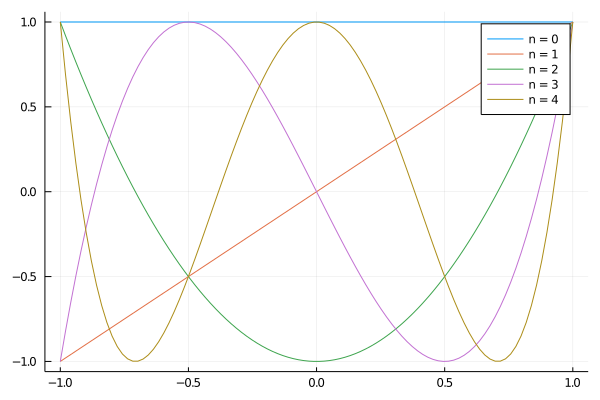

In [10]:
# Agora, vamos testar essa função plottando os cinco primeiros polinômios
    GridTest = range(-1, 1, length = 100)
    plot(GridTest, ones(100), label = "n = 0")
    for i in 1:4
        Cheb = zeros(100)
        for j in 1:100
            Cheb[j] = Cheb_Poly(i, GridTest[j])
        end
        plot!(GridTest, Cheb, label = "n = " * string(i))
    end
    current()

In [11]:
# Criamos uma função que usa os polinômios de Chebychev para criar a função consumo
    function C_hat(γ, K, d)
        Z = 2*(K - θk_low)/(θk_high - θk_low) - 1
        params_size = d + 1
        Soma = 0
        for i in 1:params_size
            Soma += γ[i] * Cheb_Poly(i - 1, Z)
        end
        return Soma
    end

C_hat (generic function with 1 method)

In [12]:
# Criamos uma função que, dado K, nos entrega K'
    function Find_K_prime(K, z, C_func)
        K_prime = z*(K^α) + (1-δ)*K - C_func
        return K_prime
    end

Find_K_prime (generic function with 1 method)

In [13]:
# Criamos a função de resíduos
    function R(γ, K, d, j)
        Co = C_hat(γ[j,:], K, d)
        K_prime = Find_K_prime(K, Θz[j], Co)
        Aux1 = zeros(N)
        Aux2 = zeros(N)
        for s in 1:N
            C_prime = C_hat(γ[s,:], K_prime, d)
            Aux1[s] = (1 - δ + α*Θz[s]*K_prime^(α-1))
            Aux2[s] = (C_prime/Co)^(-μ)
        end
        Aux = Aux1 .* Aux2
        R_calc = β * transpose(Pz[j,:]) * Aux - 1
        #R_calc = β * (C_prime/Co)^(-μ) * (1 - δ + α*z*K_prime^(α-1)) - 1
        return R_calc
    end

R (generic function with 1 method)

In [14]:
# Criamos uma função que encontra as raízes do Polinômio de Chebychev de d+1 graus
    function Find_Root_Cheb(d)
        params_size = d + 1
        Roots = zeros(params_size)
        Kgrid_roots = zeros(params_size)
        for i in 1:params_size
            Roots[i] = - cos((2*i - 1)/(2*params_size) * pi)
            Kgrid_roots[i] = (1 + Roots[i])/2 * (θk_high - θk_low) + θk_low
        end
        return Roots, Kgrid_roots
    end

Find_Root_Cheb (generic function with 1 method)

In [15]:
# Criamos uma função que junta tudo e devolve o sistema de equações lineares
    function Build_System(γ, d)
        params_size = d + 1
        matr = zeros(N, params_size)
        roots, K_roots = Find_Root_Cheb(d)
        for j in 1:N
            for i in 1:params_size
                matr[j,i] = R(γ, K_roots[i], d, j)
            end
        end
        return matr
    end

Build_System (generic function with 1 method)

In [16]:
# Agora, vamos criar o algoritmo que monta o sistema não-linear de interesse
    # Escolhemos um polinômio de grau 3
    d = 5

    # Calibramos o papite inicial de gamma para garantir a convergência para a solução
    γ = zeros(N, d + 1)
    γ[:,1] = c_ss * ones(N)
    γ[:,2] = 0.3 * ones(N)
    γ[:,3] = 0.001 * ones(N)

    # Criamos os objetos de interesse
    Build_system_test = zeros(N, d + 1)
    C_star = zeros(N, Nk);

In [17]:
# Montamos e resolvemos o sistema não-linear que será a base para encontrar C_star
    @time begin
        using NLsolve
        function f!(F, x)
            Aux = Build_System(x, d)
            Aux = vec(Aux)
            #println("O sistema foi construído.")
            size = (d+1)*N
            for i in 1:size
                F[i] = Aux[i]
            end
        end
        γ = nlsolve(f!, float(γ), iterations = 10000).zero
        Build_system_test = Build_System(γ, d);
    end

  8.950594 seconds (33.53 M allocations: 1.440 GiB, 7.86% gc time)


7×6 Array{Float64,2}:
 -1.01524e-10  -1.61624e-11  -4.65183e-13  …  -1.11022e-15  -4.44089e-16
 -3.81388e-11  -5.5892e-12   -1.4011e-13      -1.33227e-15   0.0
 -1.11944e-11  -1.46194e-12  -3.07532e-14      0.0           0.0
 -2.79754e-12  -3.19744e-13  -5.9952e-15      -1.11022e-16   4.44089e-16
 -6.13065e-13  -6.13953e-14  -1.55431e-15      2.22045e-16  -1.11022e-16
 -1.22014e-13  -1.15463e-14   4.44089e-16  …  -1.11022e-16   0.0
 -2.64233e-14  -2.66454e-15   0.0              0.0           2.22045e-16

In [18]:
# Preenchemos a função consumo usando o peso ótimo
    for j in 1:N
        for s in 1:Nk
            C_star[j,s] = C_hat(γ[j,:], Θk[s], d)
        end
    end

# Verificamos se o sistema foi de fato zerado
    Erro_max = maximum(broadcast(abs, Build_system_test))

    println("O erro máximo foi de ", Erro_max)

O erro máximo foi de 1.0152412244224251e-10


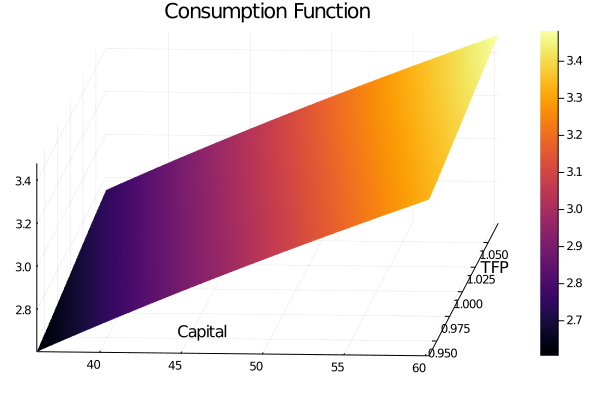

In [19]:
# Plottamos a função consumo resultante
    plot(Θk, Θz , C_star, st=:surface, title = "Consumption Function", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

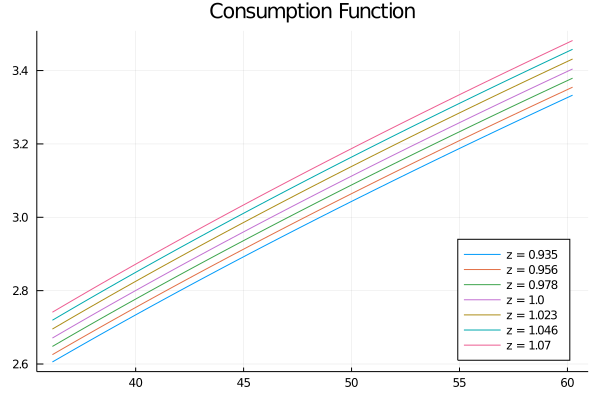

In [20]:
# Plottamos a função consumo para cada z
    plot(Θk, C_star[1,:], title = "Consumption Function", label = "z = " * string(round(Θz[1]; digits = 3)), legend=:bottomright)
    for j in 2:N
        plot!(Θk, C_star[j,:], label = "z = " * string(round(Θz[j]; digits = 3)))
    end
    current()

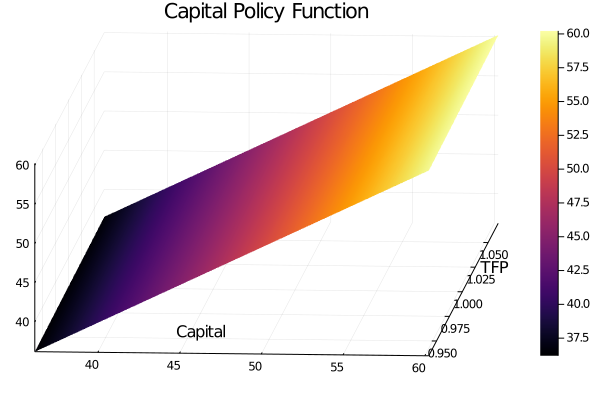

In [21]:
# Em seguida, devemos encontrar a função política para o capital
    K_prime_star = zeros(N, Nk)
    for j in 1:N
        for i in 1:Nk
            K_prime_star[j,i] = Θz[j]*Θk[i]^α + (1-δ)*Θk[i] - C_star[j,i]
        end
    end

# Plottamos a função política resultante
    plot(Θk, Θz , K_prime_star, st=:surface, title = "Capital Policy Function", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

In [22]:
# Resta agora encontrar a função valor do problema
# Uma função auxiliar que acha o capital no grid
    function FindK(k, Nk, Θk)
        ans = 0
        for i in 1:Nk
            if k == Θk[i]
                ans = i
                break
            end
        end
        return ans
    end

# Para isso, criamos uma função que itera usando K_prime, sem maximizar
    function Contraction_wo_max(Vo, K)
        # Simply update using previous K', without maximizing
        Nk = size(Vo)[2]
        Θk = range(0.75*k_ss, 1.25*k_ss, length = Nk)
        V = zeros(N,Nk)
        Kprime = K
        for i in 1:N
            for j in 1:Nk
                c = (1-δ)*Θk[j] + Θz[i]*(Θk[j]^α) - K[i,j]
                V[i,j] = u(c,μ) + β*transpose(Pz[i,:])*Vo[:,FindK(K[i,j], Nk, Θk)]
            end
        end
        return V, Kprime
    end

Contraction_wo_max (generic function with 1 method)

In [23]:
# Tomamos a menor distância para o grid
    K_star_grid = zeros(N, Nk)
    for i in 1:N
        for j in 1:Nk
            Dist = K_prime_star[i,j] .- Θk
            Dist = broadcast(abs, Dist)
            K_star_grid[i,j] = Θk[argmin(Dist)]
        end
    end

In [24]:
# Finalmente, a função valor
    tol = 10^(-6)
    error = 1
    Max_Iter = 1200
    Iter = 0

    Vo = zeros(N, Nk)
    # Esse processo demora mais ou menos 2 minutos
    @time begin
        while error >= tol && Iter <= Max_Iter
            V, K = Contraction_wo_max(Vo, K_star_grid)
            error = maximum(broadcast(abs, V-Vo))
            Vo = V
            Iter = Iter + 1
            println("Erro da iteração ", Iter, " foi de ", error, ".")
        end

# Imprimimos o resumo do procedimento
    if error < tol
        println("Converged in ", Iter, " iterations.")
    else
        println("Não houve convergência.")
    end
    end


Erro da iteração 1 foi de 0.7121071773256438.
Erro da iteração 2 foi de 0.7025917228712077.
Erro da iteração 3 foi de 0.6934337271793052.
Erro da iteração 4 foi de 0.6843455372653189.
Erro da iteração 5 foi de 0.6753374406767128.
Erro da iteração 6 foi de 0.666415791971966.
Erro da iteração 7 foi de 0.6575767801637991.
Erro da iteração 8 foi de 0.6486187535027321.
Erro da iteração 9 foi de 0.6398182760118125.
Erro da iteração 10 foi de 0.6311661953137122.
Erro da iteração 11 foi de 0.6226535713914414.
Erro da iteração 12 foi de 0.6142707504734748.
Erro da iteração 13 foi de 0.6059703294175671.
Erro da iteração 14 foi de 0.5977649166917445.
Erro da iteração 15 foi de 0.5896750652991116.
Erro da iteração 16 foi de 0.5816851606373881.
Erro da iteração 17 foi de 0.5738047844579128.
Erro da iteração 18 foi de 0.5660272961053252.
Erro da iteração 19 foi de 0.5583594150898694.
Erro da iteração 20 foi de 0.5507956945749921.
Erro da iteração 21 foi de 0.5433414439826851.
Erro da iteração 22 foi

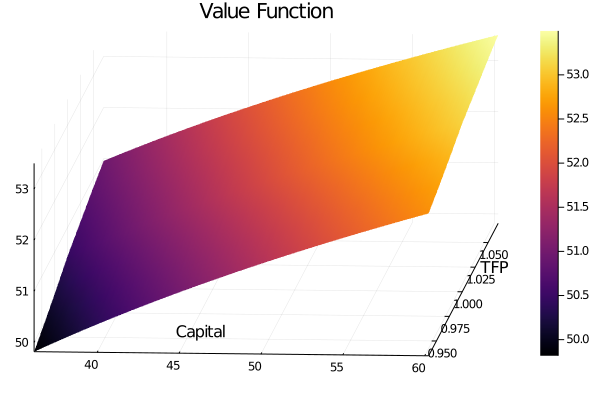

In [25]:
# Atribuimos o resultado e plottamos
    V_star = Vo
    plot(Θk, Θz , V_star, st=:surface, title = "Value Function", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

In [26]:
# Agora, vamos construir os EEE (Euler Equation Errors)
# Para isso, construimos a derivada da utilidade
    function u_prime(c, μ)
        c = Float64(c)
        if μ == 1
            u = 1/c
        else
            u = c^(-μ)
        return u
        end
    end

# E também a inversa da derivada
    function u_prime_inv(x, μ)
        x = Float64(x)
        if μ == 1
            u = 1/x
        else
            u = x^(-1/μ)
        return u
        end
    end

u_prime_inv (generic function with 1 method)

In [27]:
# Criamos a matriz que receberá os erros
    EEE = zeros(N, Nk)
    for i in 1:N
        for j in 1:Nk
            aux1 = zeros(N)
            aux2 = zeros(N)
            for s in 1:N
                aux1[s] = ((1-δ) + α*Θz[s]*(K_star_grid[i,j])^(α-1))
                aux2[s] = u_prime(C_star[s, FindK(K_star_grid[i,j], Nk, Θk)], μ)
            end
            aux = aux1 .* aux2
            EEE[i,j] = log(10, abs(1 - (u_prime_inv(β*transpose(Pz[i,:])*aux, μ))/C_star[i,j]))
        end
    end

In [28]:
# Avaliamos os EEE
    a = maximum(EEE)
    b = mean(EEE)

println("O erro de Euler máximo foi de ", round(a; digits = 2), " o que representa um erro de 1 dólar a cada ", round(10^(-a); digits = 2), " dólares gastos.")
println("O erro de Euler médio foi de ", round(b; digits = 2), " o que representa um erro de 1 dólar a cada ", round(10^(-b); digits = 2), " dólares gastos.")

O erro de Euler máximo foi de -3.52 o que representa um erro de 1 dólar a cada 3275.04 dólares gastos.
O erro de Euler médio foi de -4.05 o que representa um erro de 1 dólar a cada 11306.8 dólares gastos.


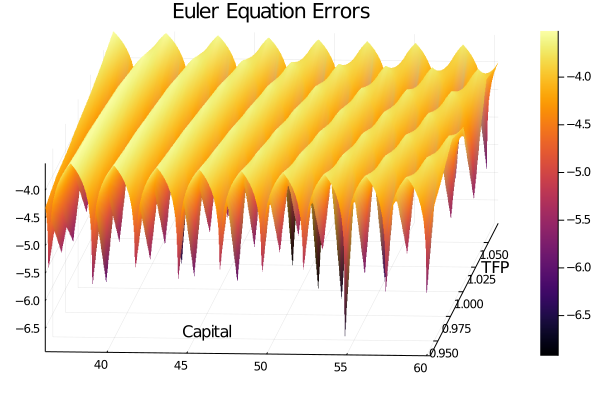

In [29]:
# Plotando os EEE (3d)
    x = Θk
    y = Θz
    z = EEE
    plot(x,y,z,st=:surface, title = "Euler Equation Errors", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

## Exercício 2 - Métodos de Elementos Finitos

#### Método de Colocação

In [30]:
@time begin
        d = 1                # Ao lidar com intervalos pequenos, vamos usar grau menor
        params_size = d + 1
        Inter = Nk - 1       # Número de intervalos nos quais iremos particionar
        All_points = Vector{Float64}()
        Consumo = zeros(N, (d+1)*Inter)

        for t in 1:Inter
            # Definimos os pontos de colocação
            Intervalo_baixo = Θk[t]
            Intervalo_alto = Θk[t+1]
            # Colocamos no primeiro e terceiro quartos para não haver pontos comuns entre os intervalos
            P1 = (Intervalo_alto - Intervalo_baixo)*(1/4) + Intervalo_baixo
            P2 = (Intervalo_alto - Intervalo_baixo)*(3/4) + Intervalo_baixo
            Pontos = [P1, P2]
            append!(All_points, Pontos)

            # Damos o palpite inicial de pesos
            γ = zeros(N, d + 1)
            γ[:,1] = c_ss * ones(N)
            γ[:,2] = 0.3 * ones(N)

            # Montamos o sistema não-linear e resolvemos
            using NLsolve
            function f!(F, x)
                matriz = zeros(N, params_size)
                for j in 1:N
                    for i in 1:params_size
                        matriz[j,i] = R(x, Pontos[i], d, j)
                    end
                end
                Conditions = vec(matriz)

                size = (d+1)*N
                for i in 1:size
                    F[i] = Conditions[i]
                end
            end
            γ = nlsolve(f!, float(γ), iterations = 10000).zero
            Test = zeros(N, params_size)
            for j in 1:N
                for i in 1:params_size
                    Test[j,i] = R(γ, Pontos[i], d, j)
                end
            end
            Erro = maximum(broadcast(abs, Test))

            # Preenchemos agora a função de consumo
            for j in 1:N
                Consumo[j, 2*t - 1] = C_hat(γ[j,:], Pontos[1], d)
                Consumo[j, 2*t] = C_hat(γ[j,:], Pontos[2], d)
            end

            # Finalmente, um test para mostrar que o processo está andando.
            if Erro < 10e-8
                println("O intervalo ", t, " funcionou corretamente.")
            else
                println("O intervalo ", t, " não funcionou corretamente.")
                break
            end
        end
    end

O intervalo 1 funcionou corretamente.
O intervalo 2 funcionou corretamente.
O intervalo 3 funcionou corretamente.
O intervalo 4 funcionou corretamente.
O intervalo 5 funcionou corretamente.
O intervalo 6 funcionou corretamente.
O intervalo 7 funcionou corretamente.
O intervalo 8 funcionou corretamente.
O intervalo 9 funcionou corretamente.
O intervalo 10 funcionou corretamente.
O intervalo 11 funcionou corretamente.
O intervalo 12 funcionou corretamente.
O intervalo 13 funcionou corretamente.
O intervalo 14 funcionou corretamente.
O intervalo 15 funcionou corretamente.
O intervalo 16 funcionou corretamente.
O intervalo 17 funcionou corretamente.
O intervalo 18 funcionou corretamente.
O intervalo 19 funcionou corretamente.
O intervalo 20 funcionou corretamente.
O intervalo 21 funcionou corretamente.
O intervalo 22 funcionou corretamente.
O intervalo 23 funcionou corretamente.
O intervalo 24 funcionou corretamente.
O intervalo 25 funcionou corretamente.
O intervalo 26 funcionou corretame

In [31]:
# Devemos Interpolar essa função consumo de volta para o grid inicial
    using DataInterpolations
    Consumo_FEA = zeros(N, Nk)
    for i in 1:N
        interp = CubicSpline(Consumo[i,:], All_points)
        # Interpolates the Value of Consumo over the points of the previous grid
        for j in 1:Nk
            Consumo_FEA[i,j] = interp(Θk[j])
        end
    end

    a = maximum(broadcast(abs, C_star - Consumo_FEA))
    b = mean(broadcast(abs, C_star - Consumo_FEA))
    println("A diferença máxima entre o consumo em método global e elementos finitos foi de ", round(a; digits = 4))
    println("A diferença média entre o consumo em método global e elementos finitos foi de ", round(b; digits = 4))

A diferença máxima entre o consumo em método global e elementos finitos foi de 0.0142
A diferença média entre o consumo em método global e elementos finitos foi de 0.0034


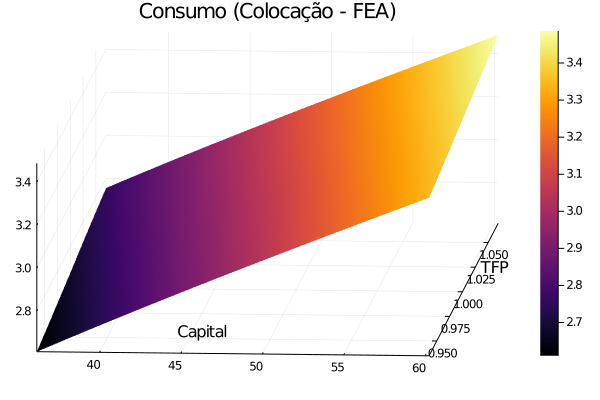

In [32]:
# Agora, iremos plottar a função consumo resultante (3d)
    plot(Θk, Θz , Consumo_FEA, st=:surface, title = "Consumo (Colocação - FEA)", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

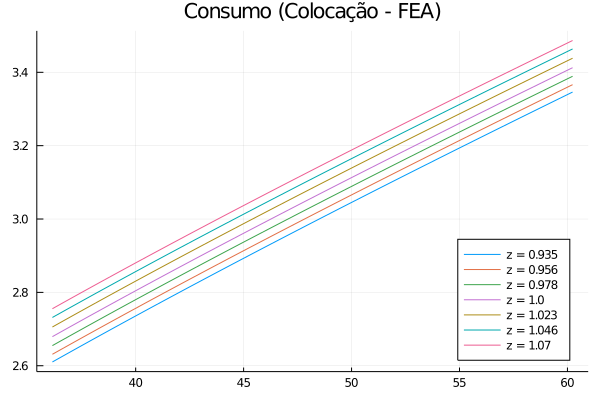

In [33]:
# Plottamos a função consumo para cada z
    plot(Θk, Consumo_FEA[1,:], title = "Consumo (Colocação - FEA)", label = "z = " * string(round(Θz[1]; digits = 3)), legend=:bottomright)
    for j in 2:N
        plot!(Θk, Consumo_FEA[j,:], label = "z = " * string(round(Θz[j]; digits = 3)))
    end
    current()

In [34]:
# Em seguida, devemos encontrar a função política para o capital
    K_prime_star_FEA = zeros(N, Nk)
    for j in 1:N
        for i in 1:Nk
            K_prime_star_FEA[j,i] = Θz[j]*Θk[i]^α + (1-δ)*Θk[i] - Consumo_FEA[j,i]
        end
    end

# Tomamos a menor distância para o grid
    K_star_grid_FEA = zeros(N, Nk)
    for i in 1:N
        for j in 1:Nk
            Dist = K_prime_star[i,j] .- Θk
            Dist = broadcast(abs, Dist)
            K_star_grid_FEA[i,j] = Θk[argmin(Dist)]
        end
    end

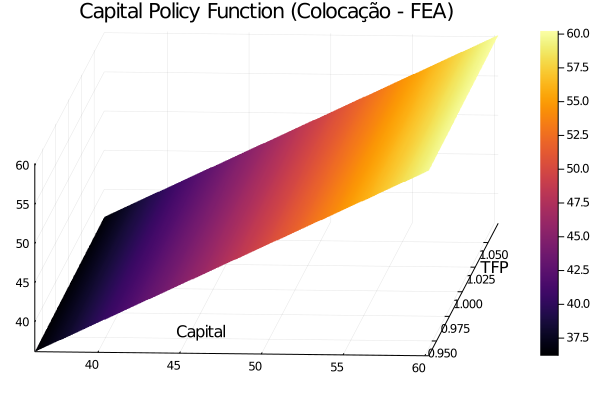

In [35]:
# Plottamos a função política resultante
    plot(Θk, Θz , K_star_grid_FEA, st=:surface, title = "Capital Policy Function (Colocação - FEA)", xlabel = "Capital",
            ylabel = "TFP", legend=:bottom, camera =(10,50))

In [36]:
# Finalmente, a função valor
    tol = 10^(-6)
    error = 1
    Max_Iter = 1200
    Iter = 0

    Vo = zeros(N, Nk)
    # Esse processo demora mais ou menos 2 minutos
    @time begin
        while error >= tol && Iter <= Max_Iter
            V, K = Contraction_wo_max(Vo, K_star_grid_FEA)
            error = maximum(broadcast(abs, V-Vo))
            Vo = V
            Iter = Iter + 1
            println("Erro da iteração ", Iter, " foi de ", error, ".")
        end

# Imprimimos o resumo do procedimento
    if error < tol
        println("Converged in ", Iter, " iterations.")
    else
        println("Não houve convergência.")
    end
    end

Erro da iteração 1 foi de 0.7121071773256438.
Erro da iteração 2 foi de 0.7025917228712077.
Erro da iteração 3 foi de 0.6934337271793052.
Erro da iteração 4 foi de 0.6843455372653189.
Erro da iteração 5 foi de 0.6753374406767128.
Erro da iteração 6 foi de 0.666415791971966.
Erro da iteração 7 foi de 0.6575767801637991.
Erro da iteração 8 foi de 0.6486187535027321.
Erro da iteração 9 foi de 0.6398182760118125.
Erro da iteração 10 foi de 0.6311661953137122.
Erro da iteração 11 foi de 0.6226535713914414.
Erro da iteração 12 foi de 0.6142707504734748.
Erro da iteração 13 foi de 0.6059703294175671.
Erro da iteração 14 foi de 0.5977649166917445.
Erro da iteração 15 foi de 0.5896750652991116.
Erro da iteração 16 foi de 0.5816851606373881.
Erro da iteração 17 foi de 0.5738047844579128.
Erro da iteração 18 foi de 0.5660272961053252.
Erro da iteração 19 foi de 0.5583594150898694.
Erro da iteração 20 foi de 0.5507956945749921.
Erro da iteração 21 foi de 0.5433414439826851.
Erro da iteração 22 foi

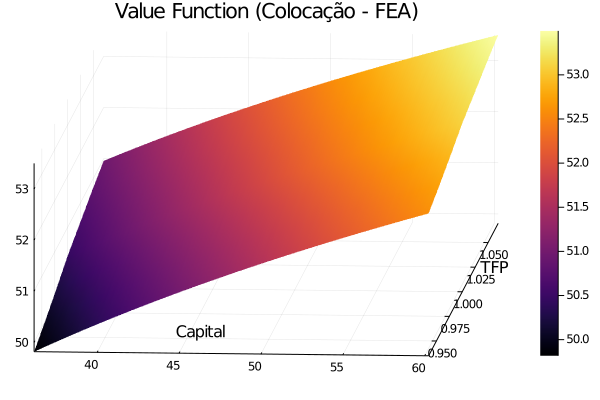

In [37]:
# Atribuimos o resultado e plottamos
    V_star_FEA = Vo
    plot(Θk, Θz , V_star_FEA, st=:surface, title = "Value Function (Colocação - FEA)", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

In [38]:
# Criamos a matriz que receberá os erros
    EEE_FEA = zeros(N, Nk)
    for i in 1:N
        for j in 1:Nk
            aux1 = zeros(N)
            aux2 = zeros(N)
            for s in 1:N
                aux1[s] = ((1-δ) + α*Θz[s]*(K_star_grid_FEA[i,j])^(α-1))
                aux2[s] = u_prime(Consumo_FEA[s, FindK(K_star_grid_FEA[i,j], Nk, Θk)], μ)
            end
            aux = aux1 .* aux2
            EEE_FEA[i,j] = log(10, abs(1 - (u_prime_inv(β*transpose(Pz[i,:])*aux, μ))/Consumo_FEA[i,j]))
        end
    end

# Avaliamos os EEE
    a = maximum(EEE_FEA)
    b = mean(EEE_FEA)

println("O erro de Euler máximo foi de ", round(a; digits = 2), " o que representa um erro de 1 dólar a cada ", round(10^(-a); digits = 2), " dólares gastos.")
println("O erro de Euler médio foi de ", round(b; digits = 2), " o que representa um erro de 1 dólar a cada ", round(10^(-b); digits = 2), " dólares gastos.")

O erro de Euler máximo foi de -3.21 o que representa um erro de 1 dólar a cada 1621.97 dólares gastos.
O erro de Euler médio foi de -4.02 o que representa um erro de 1 dólar a cada 10476.43 dólares gastos.


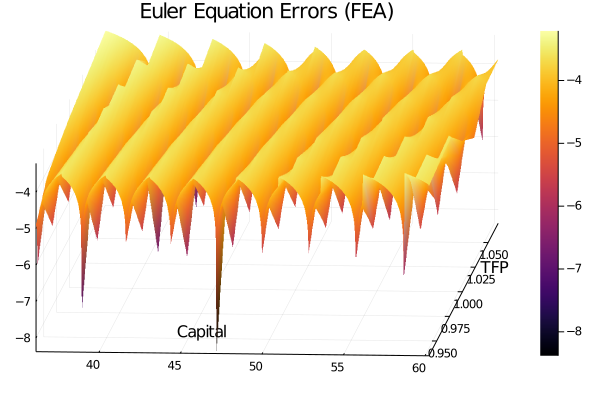

In [39]:
# Plotando os EEE (3d)
    x = Θk
    y = Θz
    z = EEE_FEA
    plot(x,y,z,st=:surface, title = "Euler Equation Errors (FEA)", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

#### Método de Galerkin

In [40]:
# Iremos particionar o espaço de capitais em 10 intervalos de 50 pontos
    N_Inter = 10
    Θk_Galerkin = range(θk_low, θk_high, length = N_Inter + 1);

In [41]:
# Em primeiro lugar, iremos criar a função ψ
    function ψ(i,k)
        valor = 0
        if i == 1
            valor = (Θk_Galerkin[i+1] - k)/(Θk_Galerkin[i+1] - Θk_Galerkin[i])
            if valor < 0 || valor > 1
                valor = 0
            end
        elseif i == (N_Inter + 1)
            valor = (k - Θk_Galerkin[i-1])/(Θk_Galerkin[i] - Θk_Galerkin[i-1])
            if valor < 0 || valor > 1
                valor = 0
            end
        else
            valor1 = (k - Θk_Galerkin[i-1])/(Θk_Galerkin[i] - Θk_Galerkin[i-1])
            valor2 = (Θk_Galerkin[i+1] - k)/(Θk_Galerkin[i+1] - Θk_Galerkin[i])
            if valor1 < 0 || valor1 > 1
                if valor2 < 0 || valor2 > 1
                    valor = 0
                else
                    valor = valor2
                end
            end
            if valor2 < 0 || valor2 > 1
                if valor1 < 0 || valor1 > 1
                    valor = 0
                else
                    valor = valor1
                end
            end
        end
        return valor
    end

ψ (generic function with 1 method)

In [42]:
# Em seguida, construímos a função que constroi o consumo com base em pesos "a"
    function Gal_cons(a, k)
        Soma = 0
        for i in 1:(N_Inter + 1)
            Soma += a[i]*ψ(i,k)
        end
        return Soma
    end

Gal_cons (generic function with 1 method)

In [43]:
# Após isso, a função que constrói os residuos
    function Gal_res(a, k, j)
        k_tilde =  Θz[j]*(k^α) + (1-δ)*k - Gal_cons(a[j,:], k)
        Aux1 = zeros(N)
        Aux2 = zeros(N)
        for s in 1:N
            C_prime = Gal_cons(a[s,:], k_tilde)
            Aux1[s] = (1 - δ + α*Θz[s]*k_tilde^(α-1))
            Aux2[s] = β*u_prime(C_prime, μ)
        end
        Aux = Aux1 .* Aux2
        res = u_prime(Gal_cons(a[j,:], k), μ) - transpose(Pz[j,:])* Aux
        return res
    end

Gal_res (generic function with 1 method)

In [44]:
# Agora, podemos calcular as integrais do Método de Galerkin usando Quadraturas
    function E_func_quad(i, a, t, j)
        Quad_pts = 6
        value = 0
        # t = 1 or 2 => above or below, respectively
        if i == 1
            if t == 1
                up = (Θk_Galerkin[i+1] - Θk_Galerkin[i])*(10/10) + Θk_Galerkin[i]
                down = (Θk_Galerkin[i+1] - Θk_Galerkin[i])*(0/10) + Θk_Galerkin[i]
                Θk_aux = range(down, up, length = Quad_pts)
                Soma = 0
                for s in 1:Quad_pts
                    x_s = (2*s-1)/(2*Quad_pts)
                    x_s = x_s * π
                    x_s = -cos(x_s)
                    k_s = 0.5 * (1 + x_s)*(Θk_aux[Quad_pts] - Θk_aux[1]) +  Θk_aux[1]
                    Soma += Gal_res(a, k_s, j)*ψ(i, k_s)*sqrt(1 - x_s^2)
                end
                value = (π * (Θk_aux[Quad_pts] - Θk_aux[1]) * Soma)/(2*Quad_pts)
            end
        elseif i == (N_Inter + 1)
            if t == 2
                up = (Θk_Galerkin[i] - Θk_Galerkin[i-1])*(10/10) + Θk_Galerkin[i-1]
                down = (Θk_Galerkin[i] - Θk_Galerkin[i-1])*(0/10) + Θk_Galerkin[i-1]
                Θk_aux = range(down, up, length = Quad_pts)
                Soma = 0
                for s in 1:Quad_pts
                    x_s = (2*s-1)/(2*Quad_pts)
                    x_s = x_s * π
                    x_s = -cos(x_s)
                    k_s = 0.5 * (1 + x_s)*(Θk_aux[Quad_pts] - Θk_aux[1]) +  Θk_aux[1]
                    Soma += Gal_res(a, k_s, j)*ψ(i, k_s)*sqrt(1 - x_s^2)
                end
                value = (π * (Θk_aux[Quad_pts] - Θk_aux[1]) * Soma)/(2*Quad_pts)
              end
          else
            if t == 1
                up = (Θk_Galerkin[i+1] - Θk_Galerkin[i])*(10/10) + Θk_Galerkin[i]
                down = (Θk_Galerkin[i+1] - Θk_Galerkin[i])*(0/10) + Θk_Galerkin[i]
                Θk_aux = range(down, up, length = Quad_pts)
                Soma = 0
                for s in 1:Quad_pts
                    x_s = (2*s-1)/(2*Quad_pts)
                    x_s = x_s * π
                    x_s = -cos(x_s)
                    k_s = 0.5 * (1 + x_s)*(Θk_aux[Quad_pts] - Θk_aux[1]) +  Θk_aux[1]
                    Soma += Gal_res(a, k_s, j)*ψ(i, k_s)*sqrt(1 - x_s^2)
                end
                value = (π * (Θk_aux[Quad_pts] - Θk_aux[1]) * Soma)/(2*Quad_pts)
            elseif t == 2
                up = (Θk_Galerkin[i] - Θk_Galerkin[i-1])*(10/10) + Θk_Galerkin[i-1]
                down = (Θk_Galerkin[i] - Θk_Galerkin[i-1])*(0/10) + Θk_Galerkin[i-1]
                Θk_aux = range(down, up, length = Quad_pts)
                Soma = 0
                for s in 1:Quad_pts
                    x_s = (2*s-1)/(2*Quad_pts)
                    x_s = x_s * π
                    x_s = -cos(x_s)
                    k_s = 0.5 * (1 + x_s)*(Θk_aux[Quad_pts] - Θk_aux[1]) +  Θk_aux[1]
                    Soma += Gal_res(a, k_s, j)*ψ(i, k_s)*sqrt(1 - x_s^2)
                end
                value = (π * (Θk_aux[Quad_pts] - Θk_aux[1]) * Soma)/(2*Quad_pts)
              end
          end
          return value
    end

E_func_quad (generic function with 1 method)

In [45]:
# Por fim, uma função que constrói o sistema todo para uma matriz de pesos "a"
    function Build_Galerkin(a)
        System = zeros(N, (N_Inter + 1))
        for j in 1:N
            for i in 1:(N_Inter + 1)
                #System[j,i] = E_func(i, a, 1, j) + E_func(i, a, 2, j)
                System[j,i] = E_func_quad(i, a, 1, j) + E_func_quad(i, a, 2, j)
            end
            #println("A linha ", j, " foi preenchida.")
        end
        return System
    end

Build_Galerkin (generic function with 1 method)

In [46]:
# Agora, precisaremos do palpite inicial para solucionar o sistema
    a = 2.5*ones(N, (N_Inter + 1))
    a[:,10] = 4*ones(N)
    a[:,11] = 4*ones(N);

In [47]:
# Montamos o sistema não-linear que será a base para encontrar C_star
    @time begin
        using NLsolve
        function f!(F, x)
            Aux = Build_Galerkin(x)
            Aux = vec(Aux)
            println("O sistema foi construído.")
            size = N*(N_Inter + 1)
            for i in 1:size
                F[i] = Aux[i]
            end
        end
        a_optimal = nlsolve(f!, float(a), ftol = 1e-6, iterations = 10000).zero
        Build_system_test = Build_Galerkin(a_optimal)
        end

    Consumo_Gal = zeros(N, Nk)
    for j in 1:N
        for s in 1:Nk
            Consumo_Gal[j,s] = Gal_cons(a_optimal[j,:], Θk[s])
        end
    end

O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema foi construído.
O sistema fo

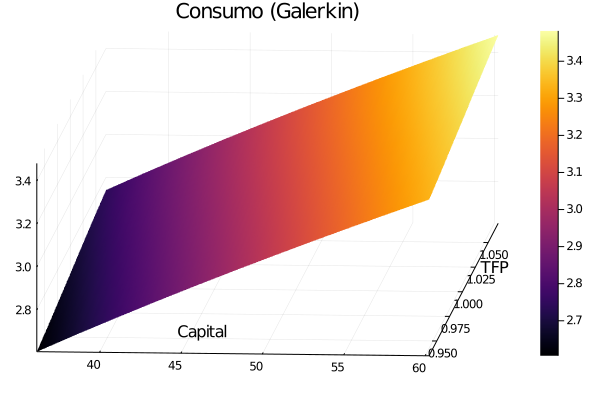

In [48]:
# Agora, iremos plottar a função consumo resultante (3d)
    plot(Θk, Θz , Consumo_Gal, st=:surface, title = "Consumo (Galerkin)", xlabel = "Capital",
        ylabel = "TFP", legend=:bottom, camera =(10,50))

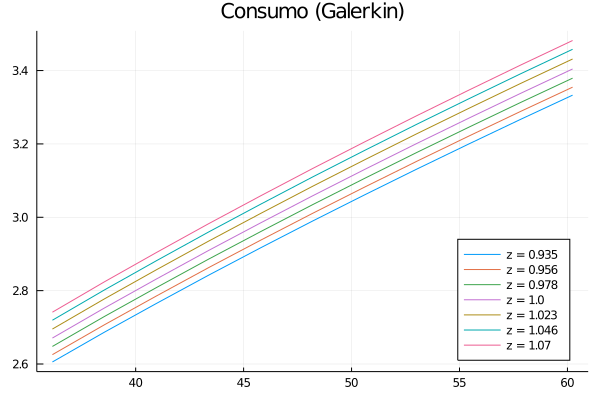

In [49]:
# Plottamos a função consumo para cada z
    plot(Θk, Consumo_Gal[1,:], title = "Consumo (Galerkin)", label = "z = " * string(round(Θz[1]; digits = 3)), legend=:bottomright)
    for j in 2:N
        plot!(Θk, Consumo_Gal[j,:], label = "z = " * string(round(Θz[j]; digits = 3)))
    end
    current()

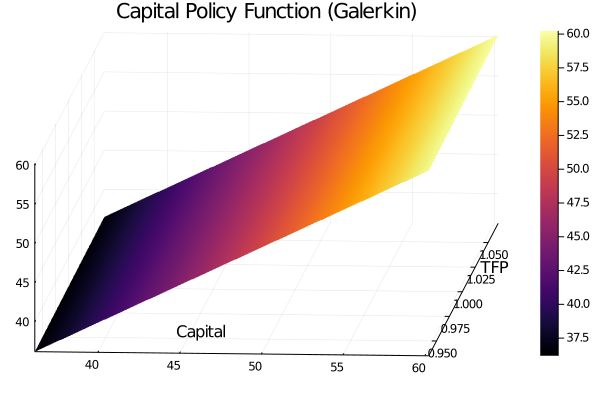

In [50]:
# Em seguida, devemos encontrar a função política para o capital
    K_prime_star_Gal = zeros(N, Nk)
    for j in 1:N
        for i in 1:Nk
            K_prime_star_Gal[j,i] = Θz[j]*Θk[i]^α + (1-δ)*Θk[i] - Consumo_Gal[j,i]
        end
    end

# Tomamos a menor distância para o grid
    K_star_grid_Gal = zeros(N, Nk)
    for i in 1:N
        for j in 1:Nk
            Dist = K_prime_star_Gal[i,j] .- Θk
            Dist = broadcast(abs, Dist)
            K_star_grid_Gal[i,j] = Θk[argmin(Dist)]
        end
    end

# Plottamos a função política resultante
    plot(Θk, Θz , K_star_grid_Gal, st=:surface, title = "Capital Policy Function (Galerkin)", xlabel = "Capital",
            ylabel = "TFP", legend=:bottom, camera =(10,50))


In [51]:
# Finalmente, a função valor
    tol = 10^(-6)
    error = 1
    Max_Iter = 1200
    Iter = 0

    Vo = zeros(N, Nk)
    # Esse processo demora mais ou menos 2 minutos
    @time begin
        while error >= tol && Iter <= Max_Iter
            V, K = Contraction_wo_max(Vo, K_star_grid_Gal)
            error = maximum(broadcast(abs, V-Vo))
            Vo = V
            Iter = Iter + 1
            println("Erro da iteração ", Iter, " foi de ", error, ".")
        end

# Imprimimos o resumo do procedimento
    if error < tol
        println("Converged in ", Iter, " iterations.")
    else
        println("Não houve convergência.")
    end
    end

Erro da iteração 1 foi de 0.7121071773256438.
Erro da iteração 2 foi de 0.7025917228712077.
Erro da iteração 3 foi de 0.6934337271793052.
Erro da iteração 4 foi de 0.6843455372653189.
Erro da iteração 5 foi de 0.6753374406767128.
Erro da iteração 6 foi de 0.666415791971966.
Erro da iteração 7 foi de 0.6575767801637991.
Erro da iteração 8 foi de 0.6486187535027321.
Erro da iteração 9 foi de 0.6398182760118125.
Erro da iteração 10 foi de 0.6311661953137122.
Erro da iteração 11 foi de 0.6226535713914414.
Erro da iteração 12 foi de 0.6142707504734748.
Erro da iteração 13 foi de 0.6059703294175671.
Erro da iteração 14 foi de 0.5977649166917445.
Erro da iteração 15 foi de 0.5896750652991116.
Erro da iteração 16 foi de 0.5816851606373881.
Erro da iteração 17 foi de 0.5738047844579128.
Erro da iteração 18 foi de 0.5660272961053252.
Erro da iteração 19 foi de 0.5583594150898694.
Erro da iteração 20 foi de 0.5507956945749921.
Erro da iteração 21 foi de 0.5433414439826851.
Erro da iteração 22 foi

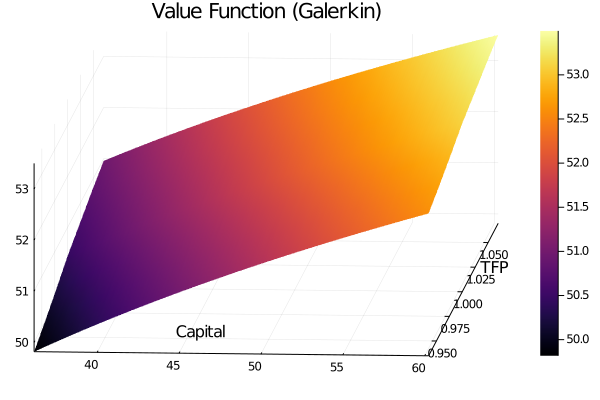

In [52]:
# Atribuimos o resultado e plottamos
    V_star_Gal = Vo
    plot(Θk, Θz , V_star_Gal, st=:surface, title = "Value Function (Galerkin)", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

In [53]:
# Criamos a matriz que receberá os erros
    EEE_Gal = zeros(N, Nk)
    for i in 1:N
        for j in 1:Nk
            aux1 = zeros(N)
            aux2 = zeros(N)
            for s in 1:N
                aux1[s] = ((1-δ) + α*Θz[s]*(K_star_grid_Gal[i,j])^(α-1))
                aux2[s] = u_prime(Consumo_Gal[s, FindK(K_star_grid_Gal[i,j], Nk, Θk)], μ)
            end
            aux = aux1 .* aux2
            EEE_Gal[i,j] = log(10, abs(1 - (u_prime_inv(β*transpose(Pz[i,:])*aux, μ))/Consumo_Gal[i,j]))
        end
    end

# Avaliamos os EEE
    a = maximum(EEE_Gal)
    b = mean(EEE_Gal)

println("O erro de Euler máximo foi de ", round(a; digits = 2), " o que representa um erro de 1 dólar a cada ", round(10^(-a); digits = 2), " dólares gastos.")
println("O erro de Euler médio foi de ", round(b; digits = 2), " o que representa um erro de 1 dólar a cada ", round(10^(-b); digits = 2), " dólares gastos.")

O erro de Euler máximo foi de -3.47 o que representa um erro de 1 dólar a cada 2921.2 dólares gastos.
O erro de Euler médio foi de -4.05 o que representa um erro de 1 dólar a cada 11212.74 dólares gastos.


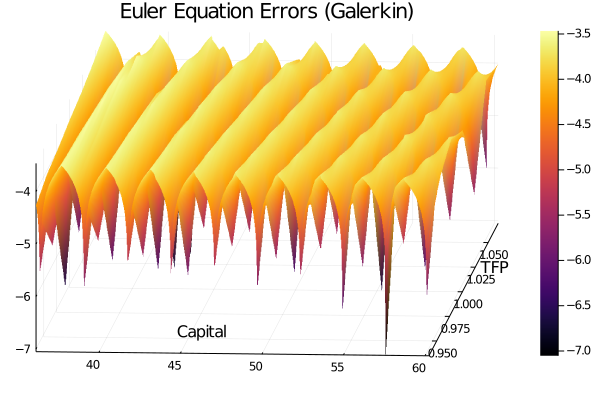

In [54]:
# Plotando os EEE (3d)
    x = Θk
    y = Θz
    z = EEE_Gal
    plot(x,y,z,st=:surface, title = "Euler Equation Errors (Galerkin)", xlabel = "Capital",
    ylabel = "TFP", legend=:bottom, camera =(10,50))

In [55]:
a = maximum(broadcast(abs, Build_system_test))
println("O erro máximo de Galerkin é ", a)

O erro máximo de Galerkin é 6.635035712678874e-8


In [56]:
# Para finalizar, vamos fazer uma comparação onde apresentamos o EEE máximo para cada método de solução

a1 = maximum(EEE)
a2 = mean(EEE)
b1 = maximum(EEE_FEA)
b2 = mean(EEE_FEA)
c1 = maximum(EEE_Gal)
c2 = mean(EEE_Gal)

varplot = [round(a1; digits=2), round(a2; digits=2), round(b1; digits=2), round(b2; digits=2), round(c1; digits=2), round(c2; digits=2)]

a3 = 10^(-a1)
a4 = 10^(-a2)
b3 = 10^(-b1)
b4 = 10^(-b2)
c3 = 10^(-c1)
c4 = 10^(-c2)

varplot2 = [round(a3; digits=0), round(a4; digits=0), round(b3; digits=0), round(b4; digits=0), round(c3; digits=0), round(c4; digits=0)]

# Apresentando a tabela (Espaço de Estados)

t1 = ["Colocação Global", "Colocação Global", "Colocação (FEA)", "Colocação (FEA)", "Galerkin (FEA)", "Galerkin (FEA)"]
t2 = ["Máximo", "Média", "Máximo", "Média", "Máximo", "Média"]
data = hcat(t1, t2, varplot, varplot2)
header = ["Método" "Referência" "EEE" "Quantos dólares para erro"]
pretty_table(data, header,
    title = "Euler Equation Error",
    tf = tf_simple,
    border_crayon = crayon"bold yellow",
    header_crayon = crayon"bold green")

Euler Equation Error
=================== ============ ======= ============================
            Método   Referência     EEE   Quantos dólares para erro  
=================== ============ ======= ============================
  Colocação Global       Máximo   -3.52                      3275.0  
  Colocação Global        Média   -4.05                     11307.0  
   Colocação (FEA)       Máximo   -3.21                      1622.0  
   Colocação (FEA)        Média   -4.02                     10476.0  
    Galerkin (FEA)       Máximo   -3.47                      2921.0  
    Galerkin (FEA)        Média   -4.05                     11213.0  
=================== ============ ======= ============================
